## ECE 239 Final Project

In this project we explore various deep learning algorithms on the EEG dataset. 


In [1]:
# Imports and setup

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM
from keras.layers import GRU
import matplotlib.pyplot as plt

from utils.load_data import *
from utils.utilities import *
from models.cnn import CNN
from models.rnn import RNN
from models.autoencoder import Autoencoder


%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# Loads data from the EEG dataset and removes all EOG data

person_train_val, X_train_val, y_train_val, person_test, X_test, y_test = load_EEG_data()

print ('Training/Valid data shape: {}'.format(X_train_val.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_val.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_val.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


### Split into train and validation datasets

In [3]:
X_train, y_train, X_val, y_val = split_train_val(X_train_val, y_train_val, percent_validation=0.1)

print ('Training data shape: {}'.format(X_train.shape))
print ('Training target shape: {}'.format(y_train.shape))
print ('Validation data shape: {}'.format(X_val.shape))
print ('Validation target shape: {}'.format(y_val.shape))

Training data shape: (1904, 22, 1000)
Training target shape: (1904,)
Validation data shape: (211, 22, 1000)
Validation target shape: (211,)


## One hot encoding for all labels

In [4]:
print (y_val[33])
print (y_val.shape)
print (y_test.shape)

y_train_labels = one_hot_encode(y_train)
y_val_labels = one_hot_encode(y_val)
y_test_labels = one_hot_encode(y_test)

print (y_val_labels[33])
print (y_val_labels.shape)
print (y_test_labels.shape)


772
(211,)
(443,)
[0. 0. 0. 1.]
(211, 4)
(443, 4)


## Viewing the data for different classes

as you can see, there is not much of a difference

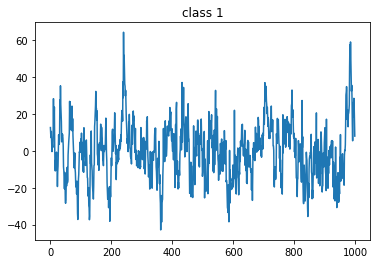

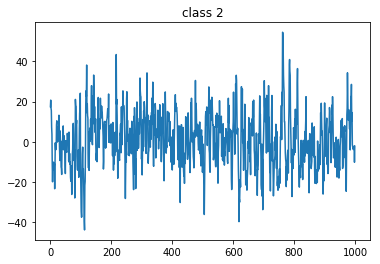

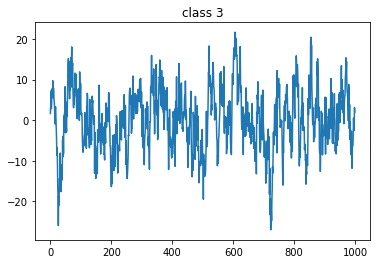

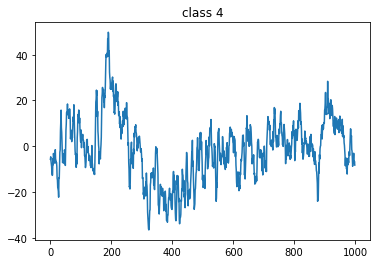

In [9]:
class1 = np.argmax( y_train == 769)
class2 = np.argmax( y_train == 770)
class3 = np.argmax( y_train == 771)
class4 = np.argmax( y_train == 772)
EEG0_class1 = X_train[class1,0,:]
EEG0_class2 = X_train[class2,0,:]
EEG0_class3 = X_train[class3,0,:]
EEG0_class4 = X_train[class4,0,:]

plt.plot(range(1000), EEG0_class1)
plt.title("class 1")
plt.show()

plt.plot(range(1000), EEG0_class2)
plt.title("class 2")
plt.show()

plt.plot(range(1000), EEG0_class3)
plt.title("class 3")
plt.show()

plt.plot(range(1000), EEG0_class4)
plt.title("class 4")
plt.show()

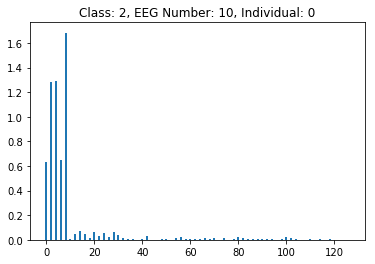

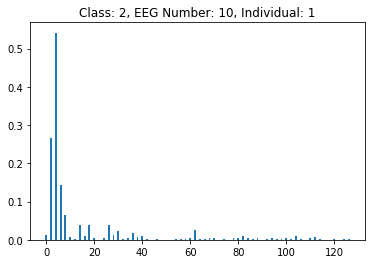

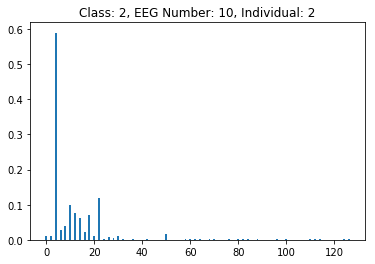

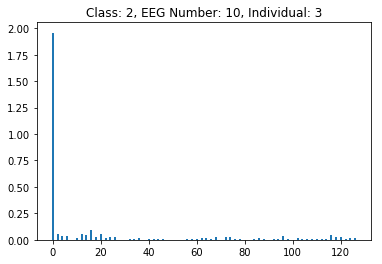

In [ ]:
class1_idx = np.argwhere(y_train==769).flatten()
class2_idx = np.argwhere(y_train==770).flatten()
class3_idx = np.argwhere(y_train==771).flatten()
class4_idx = np.argwhere(y_train==772).flatten()

class_idxs = [class1_idx, class2_idx, class3_idx, class4_idx]

EEG_NUM = 10 # 0-21
CLASS_NUM = 2 # 0,1,2,3

for i in np.arange(5):
    EEG_trial = X_train[class_idxs[CLASS_NUM][i],EEG_NUM,:]
    EEG_trial_fft, freqs = fft_electrode_data(EEG_trial)
    plt.bar(freqs, EEG_trial_fft)
    plt.title("Class: {}, EEG Number: {}, Individual: {}".format(CLASS_NUM, EEG_NUM, i))
    plt.show()

## Classifying data using a CNN

In [14]:


starts = [0, 100, 200, 300, 400, 500]
ends = [500, 600, 700, 800, 900, 1000]
downsamples = [5, 10]
bestcnn = None
bestacc = 0
bestparams = []
params_accuracies = []

for i in range(len(starts)):
    start = starts[i]
    end = ends[i]
    for downsample in downsamples:
        params = [start, end, downsample]
        print ("Training with params = " + str(params))
        cnn = CNN(X_train, y_train_labels, X_val, y_val_labels, X_test, y_test_labels,
                  start=start,end=end,downsample=downsample)
        cnn.train(stride=2, optimizer='adam', epochs=8, dropout=0.4)
        val_loss, val_accuracy = cnn.evaluate_validation()
        params_accuracies.append([params, val_accuracy])
        if (val_accuracy > bestacc):
            bestcnn = cnn
            bestacc = val_accuracy
            bestparams = params
            
print("Best val, params are: ")
print(bestacc)
print(bestparams)
#cnn.show_model()
test_loss, test_accuracy = cnn.evaluate()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

print("All params and accuracies: ")
print(params_accuracies)

Training with params = [0, 500, 5]
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 1904 samples, validate on 211 samples
Epoch 1/8
1904/1904 [==============================] - 1s 659us/sample - loss: 1.5628 - acc: 0.2558 - val_loss: 1.4205 - val_acc: 0.2275
Epoch 2/8
1904/1904 [==============================] - 1s 326us/sample - loss: 1.3305 - acc: 0.3608 - val_loss: 1.4747 - val_acc: 0.2512
Epoch 3/8
1904/1904 [==============================] - 1s 324us/sample - loss: 1.2637 - acc: 0.4233 - val_loss: 1.5121 - val_acc: 0.2607
Epoch 4/8
1904/1904 [==============================] - 1s 334us/sample - loss: 1.1809 - acc: 0.4753 - val_loss: 1.5700 - val_acc: 0.2844
Epoch 5/8
1904/1904 [==============================] - 1s 326us/sample - loss: 1.0325 - acc: 0.5452 - val_loss: 1.5924 - val_acc: 0.2844
Epoch 6/8
1904/1904 [==============================] - 1s 349us/sample - loss: 0.8940 - acc: 0.6271 - val_loss: 1.9926

Epoch 6/8
1904/1904 [==============================] - 1s 342us/sample - loss: 1.0368 - acc: 0.5578 - val_loss: 1.7174 - val_acc: 0.2844
Epoch 7/8
1904/1904 [==============================] - 1s 497us/sample - loss: 0.8845 - acc: 0.6271 - val_loss: 1.9522 - val_acc: 0.2796
Epoch 8/8
1904/1904 [==============================] - 1s 348us/sample - loss: 0.7776 - acc: 0.6812 - val_loss: 2.0621 - val_acc: 0.2559
Training with params = [300, 800, 10]
Train on 1904 samples, validate on 211 samples
Epoch 1/8
1904/1904 [==============================] - 1s 757us/sample - loss: 1.4965 - acc: 0.2584 - val_loss: 1.3987 - val_acc: 0.2749
Epoch 2/8
1904/1904 [==============================] - 1s 285us/sample - loss: 1.3767 - acc: 0.3167 - val_loss: 1.3833 - val_acc: 0.2938
Epoch 3/8
1904/1904 [==============================] - 1s 285us/sample - loss: 1.3337 - acc: 0.3661 - val_loss: 1.4508 - val_acc: 0.2844
Epoch 4/8
1904/1904 [==============================] - 1s 337us/sample - loss: 1.2707 - acc: 

## Classifying data using an LSTM Architecture

In [52]:
starts = [0, 100, 200, 300, 400, 500]
ends = [500, 600, 700, 800, 900, 1000]
downsamples = [5, 10]
bestrnn = None
bestacc = 0
bestparams = []
params_accuracies = []

for i in range(len(starts)):
    start = starts[i]
    end = ends[i]
    for downsample in downsamples:
        params = [start, end, downsample]
        print ("Training with params = " + str(params))
        rnn = RNN(X_train, y_train_labels, X_val, y_val_labels, 
                  X_test, y_test_labels,
                  start=start, end=end, downsample=downsample)
        rnn.train(RNN_architecture=LSTM, activation="softmax", \
                      optimizer='adam', epochs=5, batch_size=100, dropout=0.3, units=400)
        val_loss, val_accuracy = rnn.evaluate_validation()
        params_accuracies.append([params, val_accuracy])
        if (val_accuracy > bestacc):
            bestrnn = rnn
            bestacc = val_accuracy
            bestparams = params
            
print("Best val, params are: ")
print(bestacc)
print(bestparams)

test_loss, test_accuracy = bestrnn.evaluate()

print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

print("All params and accuracies: ")
print(params_accuracies)


Training with params = [0, 500, 5]
Train on 1904 samples, validate on 211 samples
Epoch 1/5
1904/1904 [==============================] - 24s 13ms/step - loss: 1.5329 - acc: 0.2553 - val_loss: 1.4518 - val_acc: 0.2512
Epoch 2/5
1904/1904 [==============================] - 14s 8ms/step - loss: 1.4142 - acc: 0.3009 - val_loss: 1.4034 - val_acc: 0.2796
Epoch 3/5
1904/1904 [==============================] - 15s 8ms/step - loss: 1.3728 - acc: 0.3183 - val_loss: 1.4025 - val_acc: 0.3365
Epoch 4/5
1904/1904 [==============================] - 15s 8ms/step - loss: 1.3423 - acc: 0.3629 - val_loss: 1.4341 - val_acc: 0.2796
Epoch 5/5
1904/1904 [==============================] - 15s 8ms/step - loss: 1.3307 - acc: 0.3671 - val_loss: 1.3846 - val_acc: 0.3128
Training with params = [0, 500, 10]
Train on 1904 samples, validate on 211 samples
Epoch 1/5


KeyboardInterrupt: 

## Classifying Data using a GRU Architecture

In [7]:
starts = [0, 100, 200, 300, 400, 500]
ends = [500, 600, 700, 800, 900, 1000]
downsamples = [5, 10]
bestrnn = None
bestacc = 0
bestparams = []
params_accuracies = []

for i in range(len(starts)):
    start = starts[i]
    end = ends[i]
    for downsample in downsamples:
        params = [start, end, downsample]
        print ("Training with params = " + str(params))
        rnn = RNN(X_train, y_train_labels, X_val, y_val_labels, 
                  X_test, y_test_labels,
                  start=start, end=end, downsample=downsample)
        rnn.train(RNN_architecture=GRU, activation="softmax", \
                      optimizer='adam', epochs=5, batch_size=100, dropout=0.3, units=400)
        val_loss, val_accuracy = rnn.evaluate_validation()
        params_accuracies.append([params, val_accuracy])
        if (val_accuracy > bestacc):
            bestrnn = rnn
            bestacc = val_accuracy
            bestparams = params
            
print("Best val, params are: ")
print(bestacc)
print(bestparams)

test_loss, test_accuracy = bestrnn.evaluate()

print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

print("All params and accuracies: ")
print(params_accuracies)



Training with params = [200, 700, 5]
Train on 1904 samples, validate on 211 samples
Epoch 1/5
1904/1904 [==============================] - 12s 6ms/step - loss: 1.6404 - acc: 0.2500 - val_loss: 1.4570 - val_acc: 0.2844
Epoch 2/5
1904/1904 [==============================] - 11s 6ms/step - loss: 1.5254 - acc: 0.3141 - val_loss: 1.4861 - val_acc: 0.2986
Epoch 3/5
1904/1904 [==============================] - 12s 6ms/step - loss: 1.5181 - acc: 0.3241 - val_loss: 1.4978 - val_acc: 0.3033
Epoch 4/5
1904/1904 [==============================] - 11s 6ms/step - loss: 1.4665 - acc: 0.3414 - val_loss: 1.4513 - val_acc: 0.2891
Epoch 5/5
1904/1904 [==============================] - 11s 6ms/step - loss: 1.4246 - acc: 0.3592 - val_loss: 1.5404 - val_acc: 0.2701
Training with params = [200, 700, 10]
Train on 1904 samples, validate on 211 samples
Epoch 1/5
1904/1904 [==============================] - 8s 4ms/step - loss: 1.6785 - acc: 0.2468 - val_loss: 1.4758 - val_acc: 0.2891
Epoch 2/5
1904/1904 [=======

## Autoencoder

In [6]:
normed_X_train = X_train/np.max(X_train)
normed_X_val = X_val/np.max(X_val)
normed_X_test = X_test/np.max(X_test)
normed_X_train = normed_X_train[:,:,0:500:10]
normed_X_val = normed_X_val[:,:,0:500:10]
normed_X_test = normed_X_test[:,:,0:500:10]
autoencoder = Autoencoder(normed_X_train, normed_X_val, normed_X_test)
autoencoder.train(epochs=10, encoded_dim=500)



Train on 1904 samples, validate on 211 samples
Epoch 1/10
1904/1904 [==============================] - 2s 1ms/sample - loss: 0.0062 - acc: 0.3586 - val_loss: 0.0026 - val_acc: 0.5442
Epoch 2/10
1904/1904 [==============================] - 2s 1ms/sample - loss: 0.0018 - acc: 0.6003 - val_loss: 0.0017 - val_acc: 0.6230
Epoch 3/10
1904/1904 [==============================] - 2s 1ms/sample - loss: 0.0012 - acc: 0.6576 - val_loss: 0.0013 - val_acc: 0.6484
Epoch 4/10
1904/1904 [==============================] - 2s 1ms/sample - loss: 0.0010 - acc: 0.6865 - val_loss: 0.0012 - val_acc: 0.6782
Epoch 5/10
1904/1904 [==============================] - 2s 994us/sample - loss: 8.7286e-04 - acc: 0.7034 - val_loss: 0.0011 - val_acc: 0.6919
Epoch 6/10
1904/1904 [==============================] - 2s 1ms/sample - loss: 8.1169e-04 - acc: 0.7170 - val_loss: 9.8464e-04 - val_acc: 0.7083
Epoch 7/10
1904/1904 [==============================] - 2s 1ms/sample - loss: 8.0100e-04 - acc: 0.7199 - val_loss: 9.8818e-

In [7]:
new_data = autoencoder.predict(normed_X_train)

abs_err = np.abs(normed_X_train - new_data)
print("Absolute Error in encoded data is roughly: " + str(np.mean(abs_err)))
print(normed_X_train[0,0,0:50])
print(new_data[0,0,0:50])


Absolute Error in encoded data is roughly: 0.0214954612529135
[ 0.02492669 -0.03225806  0.028348    0.11045943 -0.05718475 -0.06549365
  0.1202346   0.08064516  0.1202346   0.21749756 -0.06158358  0.00537634
  0.12952102  0.06402737 -0.02199413  0.03470186 -0.0200391  -0.1285435
  0.03616813  0.01466276 -0.07086999 -0.0801564   0.16813294 -0.10801564
  0.18426197 -0.014174   -0.06158358  0.10899316  0.23362659  0.06647116
  0.03323558  0.00879765  0.14613881  0.24340176 -0.04301075  0.04545455
 -0.04056696 -0.05180841 -0.13489736 -0.16031281 -0.08455523  0.03861193
 -0.01221896  0.03910068 -0.00977517 -0.21798631  0.17350929  0.16129032
 -0.02052786 -0.08455523]
[-0.00428058  0.01271623  0.04711392  0.11479435 -0.04470545 -0.04800601
  0.13531636  0.12476983  0.13289766  0.15559939 -0.08821362 -0.02142276
  0.16820644  0.0404432  -0.02471584  0.0551508   0.00530098 -0.13528194
  0.04333686 -0.04988718 -0.10007198 -0.10739648  0.1561942  -0.08646947
  0.16137803 -0.02404578 -0.09104803 

## Plot of original data, and autoencoded data

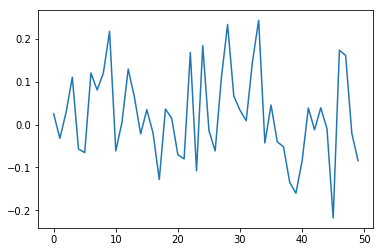

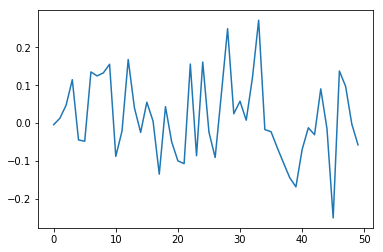

In [8]:
original = normed_X_train[0,0,:]
autoencoded = new_data[0,0,:]

plt.plot(range(len(original)), original)
plt.show()

plt.plot(range(len(autoencoded)), autoencoded)
plt.show()

## Training Final Results

In [11]:
X_train_total = np.concatenate((normed_X_train, new_data), axis=0)
y_train_total = np.concatenate((y_train_labels, y_train_labels), axis=0)

accuracies = {}
#cnnNoEncoder
cnnNoEncoder = CNN(X_train, y_train_labels, X_val, y_val_labels, X_test, y_test_labels,
                  start=0,end=500,downsample=10)
cnnNoEncoder.train(stride=2, optimizer='adam', epochs=15)
val_loss, val_accuracy = cnnNoEncoder.evaluate_validation()
accuracies['cnnNoEncoder'] = val_accuracy

#cnnEncoder
cnnEncoder = CNN(X_train_total, y_train_total, normed_X_val, y_val_labels, normed_X_test, y_test_labels,
                  start=0,end=500,downsample=10)
cnnEncoder.train(stride=2, optimizer='adam', epochs=15)
val_loss, val_accuracy = cnnEncoder.evaluate_validation()
accuracies['cnnEncoder'] = val_accuracy

#rnnNoEncoderLSTM
rnnNoEncoderLSTM = RNN(X_train, y_train_labels, X_val, y_val_labels, 
                  X_test, y_test_labels,
                  start=0, end=500, downsample=10)
rnnNoEncoderLSTM.train(RNN_architecture=LSTM, activation="softmax", \
              optimizer='adam', epochs=15, batch_size=100, dropout=0.5, units=300)
val_loss, val_accuracy = rnnNoEncoderLSTM.evaluate_validation()
accuracies['rnnNoEncoderLSTM'] = val_accuracy

#rnnEncoderLSTM
rnnEncoderLSTM = RNN(X_train_total, y_train_total, normed_X_val, y_val_labels, 
                  normed_X_test, y_test_labels,
                  start=0, end=500, downsample=10)
rnnEncoderLSTM.train(RNN_architecture=LSTM, activation="softmax", \
              optimizer='adam', epochs=15, batch_size=100, dropout=0.5, units=300)
val_loss, val_accuracy = rnnEncoderLSTM.evaluate_validation()
accuracies['rnnEncoderLSTM'] = val_accuracy

#rnnNoEncoderGRU
rnnNoEncoderGRU = RNN(X_train, y_train_labels, X_val, y_val_labels, 
                  X_test, y_test_labels,
                  start=0, end=500, downsample=10)
rnnNoEncoderGRU.train(RNN_architecture=GRU, activation="softmax", \
              optimizer='adam', epochs=15, batch_size=100, dropout=0.5, units=300)
val_loss, val_accuracy = rnnNoEncoderGRU.evaluate_validation()
accuracies['rnnNoEncoderGRU'] = val_accuracy

#rnnEncoderGRU
rnnEncoderGRU = RNN(X_train_total, y_train_total, normed_X_val, y_val_labels, 
                  normed_X_test, y_test_labels,
                  start=0, end=500, downsample=10)
rnnEncoderGRU.train(RNN_architecture=GRU, activation="softmax", \
              optimizer='adam', epochs=15, batch_size=100, dropout=0.5, units=300)
val_loss, val_accuracy = rnnEncoderGRU.evaluate_validation()
accuracies['rnnEncoderGRU'] = val_accuracy


print(accuracies)


Train on 1904 samples, validate on 211 samples
Epoch 1/15
1904/1904 [==============================] - 1s 524us/sample - loss: 1.4697 - acc: 0.2553 - val_loss: 1.3815 - val_acc: 0.2986
Epoch 2/15
1904/1904 [==============================] - 1s 289us/sample - loss: 1.3130 - acc: 0.3761 - val_loss: 1.2896 - val_acc: 0.3934
Epoch 3/15
1904/1904 [==============================] - 0s 260us/sample - loss: 1.2090 - acc: 0.4396 - val_loss: 1.3468 - val_acc: 0.3318
Epoch 4/15
1904/1904 [==============================] - 0s 253us/sample - loss: 1.0511 - acc: 0.5541 - val_loss: 1.4880 - val_acc: 0.3175
Epoch 5/15
1904/1904 [==============================] - 1s 287us/sample - loss: 0.8545 - acc: 0.6476 - val_loss: 1.5819 - val_acc: 0.3602
Epoch 6/15
1904/1904 [==============================] - 1s 279us/sample - loss: 0.7109 - acc: 0.7138 - val_loss: 1.6988 - val_acc: 0.3555
Epoch 7/15
1904/1904 [==============================] - 1s 276us/sample - loss: 0.5605 - acc: 0.7773 - val_loss: 2.0161 - val

Epoch 12/15
3808/3808 [==============================] - 1s 281us/step - loss: 1.3347 - acc: 0.3648 - val_loss: 1.3293 - val_acc: 0.3649
Epoch 13/15
3808/3808 [==============================] - 1s 266us/step - loss: 1.3326 - acc: 0.3482 - val_loss: 1.3287 - val_acc: 0.3555
Epoch 14/15
3808/3808 [==============================] - 1s 266us/step - loss: 1.3352 - acc: 0.3543 - val_loss: 1.3419 - val_acc: 0.3270
Epoch 15/15
3808/3808 [==============================] - 1s 287us/step - loss: 1.3358 - acc: 0.3419 - val_loss: 1.3362 - val_acc: 0.3507
Train on 1904 samples, validate on 211 samples
Epoch 1/15
1904/1904 [==============================] - 5s 3ms/step - loss: 1.7799 - acc: 0.2400 - val_loss: 1.5335 - val_acc: 0.3033
Epoch 2/15
1904/1904 [==============================] - 3s 2ms/step - loss: 1.6638 - acc: 0.2637 - val_loss: 1.4423 - val_acc: 0.2891
Epoch 3/15
1904/1904 [==============================] - 3s 2ms/step - loss: 1.5928 - acc: 0.2841 - val_loss: 1.4681 - val_acc: 0.2749
Epo